# **Import libraries and data**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imblearn
import keras

from keras.models import Sequential
from keras.regularizers import L1L2
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout, Activation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
from scipy.ndimage.filters import uniform_filter1d
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**Read CSV files**

The dataset from Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

In [2]:
# read and replace NaN values with 0
train_df = pd.read_csv('/content/drive/MyDrive/exoplanet_hunting/csv/exoTrain.csv').fillna(0)
valid_df = pd.read_csv('/content/drive/MyDrive/exoplanet_hunting/csv/exoTest.csv').fillna(0)
# display first 5 rows dataframe
print(train_df.head(5))
# Train shape: (5087, 3198)
# Test dhape: (570, 3198)

   LABEL   FLUX.1   FLUX.2   FLUX.3  ...  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197
0      2    93.85    83.81    20.10  ...      39.32      61.42       5.08     -39.54
1      2   -38.88   -33.83   -58.54  ...     -11.70       6.46      16.00      19.93
2      2   532.64   535.92   513.73  ...     -11.80     -28.91     -70.02     -96.67
3      2   326.52   347.39   302.35  ...      -8.77     -17.31     -17.35      13.98
4      2 -1107.21 -1112.59 -1118.95  ...    -399.71    -384.65    -411.79    -510.54

[5 rows x 3198 columns]


**Convert label**

The dataset indicates that '2' represents for the star contain at least 1 exoplanet in orbit (means it has exoplanet), and '1' represents that it does not.
So, convert these to binary for easier work with. 

In [3]:
# '2', '1' -> '1', '0'
train_df['LABEL'] = train_df['LABEL'] - 1 
valid_df['LABEL'] = valid_df['LABEL'] - 1
print(train_df.head(5))

   LABEL   FLUX.1   FLUX.2   FLUX.3  ...  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197
0      1    93.85    83.81    20.10  ...      39.32      61.42       5.08     -39.54
1      1   -38.88   -33.83   -58.54  ...     -11.70       6.46      16.00      19.93
2      1   532.64   535.92   513.73  ...     -11.80     -28.91     -70.02     -96.67
3      1   326.52   347.39   302.35  ...      -8.77     -17.31     -17.35      13.98
4      1 -1107.21 -1112.59 -1118.95  ...    -399.71    -384.65    -411.79    -510.54

[5 rows x 3198 columns]


In [4]:
# split label from train and valid set
y_train = train_df['LABEL']
y_valid = valid_df['LABEL']
# remove label in train and valid set
x_train = train_df.drop(columns='LABEL')
x_valid = valid_df.drop(columns='LABEL')
# x_train: (5087, 3197)
# y_train: (5087,)
# x_valid: (570, 3197)
# y_valid: (570,)

In [5]:
print(x_train.head(5))

    FLUX.1   FLUX.2   FLUX.3  ...  FLUX.3195  FLUX.3196  FLUX.3197
0    93.85    83.81    20.10  ...      61.42       5.08     -39.54
1   -38.88   -33.83   -58.54  ...       6.46      16.00      19.93
2   532.64   535.92   513.73  ...     -28.91     -70.02     -96.67
3   326.52   347.39   302.35  ...     -17.31     -17.35      13.98
4 -1107.21 -1112.59 -1118.95  ...    -384.65    -411.79    -510.54

[5 rows x 3197 columns]


# **Analyze data**
**Count the quantity of each label**

   LABEL  QUANTITY
0      0      5050
1      1        37


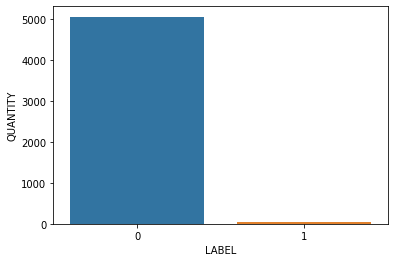

In [6]:
# group every examples which have same label and count
count_labels = y_train.groupby(by=y_train).count()
count_labels = count_labels.to_frame(name='QUANTITY')
count_labels = count_labels.reset_index()
print(count_labels)
# plot the quantity of 2 labels
sns.barplot(x='LABEL', y='QUANTITY', data=count_labels)

**Plot to see flux pattern of some star**

Let take a look at the different in flux pattern of stars have exoplanet and stars does not.

Because a star is orbited by a planet (if it has). So, the star's light intensity value that Kepler captured will drop when the star is partially obscured by the planet (from Kepler view). And intensity value rise back once the planet get away Kepler view. 

> *In other word, the intensity value of star which has exoplanet changes periodic.*

<iframe src='https://gfycat.com/ifr/ViciousThatIcelandichorse' frameborder='0' scrolling='no' allowfullscreen width='640' height='412'></iframe><p> <a href="https://gfycat.com/viciousthaticelandichorse">via Gfycat</a></p>



   index  FLUX.1  FLUX.2  FLUX.3  ...  FLUX.97  FLUX.98  FLUX.99  FLUX.100
0      0   93.85   83.81   20.10  ...  -232.76  -204.85  -128.70   -135.63
1      1  -38.88  -33.83  -58.54  ...   -12.34   -26.87    -3.65    -27.30
2      2  532.64  535.92  513.73  ...  -166.31  -175.36  -170.64   -118.39

[3 rows x 101 columns]
     index Flux Index  Flux Intensity
0        0     FLUX.1           93.85
1        1     FLUX.1          -38.88
2        2     FLUX.1          532.64
3        0     FLUX.2           83.81
4        1     FLUX.2          -33.83
..     ...        ...             ...
295      1    FLUX.99           -3.65
296      2    FLUX.99         -170.64
297      0   FLUX.100         -135.63
298      1   FLUX.100          -27.30
299      2   FLUX.100         -118.39

[300 rows x 3 columns]


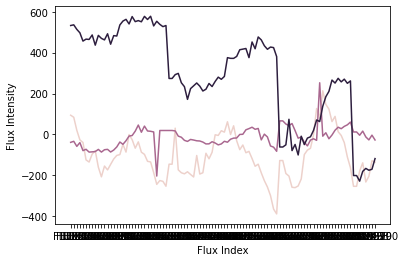

In [7]:
# extract first 3 stars (rows) which have exoplanet (label 1)
# and 100 column (flux) respective
exo_df = x_train[y_train==1].loc[:2, :'FLUX.100'].reset_index()
print(exo_df)
# transform all values into a column to pass to y-axis of graph
exo_df = exo_df.melt(id_vars=['index'], value_name='Flux Intensity', var_name='Flux Index')
print(exo_df)

sns.lineplot(x='Flux Index', y='Flux Intensity', hue='index', data=exo_df, legend=False)

   index  FLUX.1  FLUX.2  FLUX.3  ...  FLUX.97  FLUX.98  FLUX.99  FLUX.100
0     40 -167.02 -137.65 -150.05  ...  -113.70   -98.91   -44.09   -115.75
1     41  207.74  223.60  246.15  ...  -110.37  -114.56   -69.95    -59.61
2     42  174.65  167.49  169.56  ...  -191.62  -223.82  -186.21   -224.62

[3 rows x 101 columns]


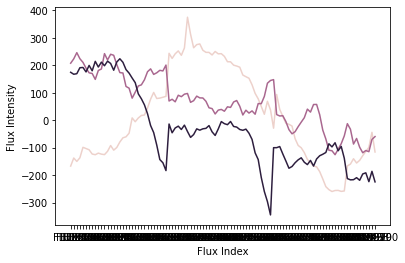

In [8]:
# extract 3 stars (rows) which doesn't have exoplanet (label 1)
# star doesn't has planet start from row 37 til the end 
non_exo_df = x_train[y_train==0].loc[40:42, :'FLUX.100'].reset_index()
print(non_exo_df)
non_exo_df = non_exo_df.melt(id_vars=['index'], value_name='Flux Intensity', var_name='Flux Index')

sns.lineplot(x='Flux Index', y='Flux Intensity', hue='index', data=non_exo_df, legend=False)

# **Data processing**

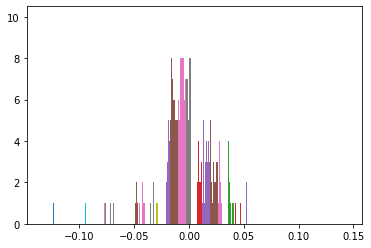

In [9]:
# nomalize data to take value between 0 and 1
x_train = normalize(x_train)
x_valid = normalize(x_valid)

plt.hist(x_valid[:10, :500])
plt.show()

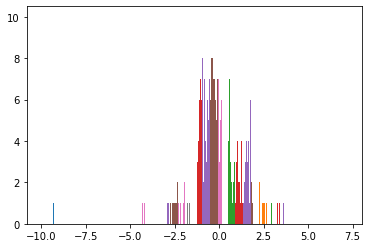

In [10]:
# standardize data to take mean = 0 and standard deviation = 1
x_train = StandardScaler().fit_transform(x_train)
x_valid = StandardScaler().fit_transform(x_valid)

plt.hist(x_valid[:10, :500])
plt.show()

**Resampling minority class**

Previouly, we saw an extremely large imbalance in the quantity of both classes. If we just take this data, our models could just predict every star is star doesn't have exoplanet (predict all label '0') and it's still give out very high accuracy, more than 90% (because 99.3% of stars have label '0').

There are 4 ways to solve class imbalance problems like this:

*   Synthesis of new minority class instances
*   Over-sampling of minority class
*   Under-sampling of the majority class
*   Tweak the cost function to make misclassification of minority instances more important than misclassification of majority instances.

Here we'll use **SMOTE** (Synthetic Minority Over-Sampling Technique) over-sampling method. It create synthetic (not duplicate) samples of minority class. SMOTE will select minority examples and altering that one column at a time by random amount.

**NOTE:** It's just improve when we train in model, NOT completely solve the imbalance.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(10100, 3197)

    index  QUANTITY
0      0      5050
1      1      5050


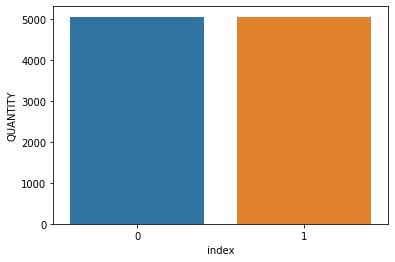

In [11]:
# resample train dataset
sm = SMOTE()
x_resampled, y_resampled = sm.fit_resample(x_train, y_train)
# count the quantity of each label after resample
print(x_resampled.shape)
unique, counts = np.unique(y_resampled, return_counts=True)
count_labels_resampled = pd.DataFrame(counts, columns=['QUANTITY']).reset_index()
# plot quantity of both labels
sns.barplot(x='index', y='QUANTITY', data=count_labels_resampled)
print('\n', count_labels_resampled)

# **Build a model**
**Shuffle train and valid set**

In [12]:
x_resampled, y_resampled = shuffle(x_resampled, y_resampled)
x_valid, y_valid = shuffle(x_valid, y_valid)

**One-hot encode**

One-hot encode our labels in to categorical matix.

In [13]:
y_train_encoded = to_categorical(y_resampled)
y_valid_encoded = to_categorical(y_valid)
print(y_train_encoded.shape)        # (10100, 2)
print(y_valid_encoded.shape)        # (570, 2)

(10100, 2)
(570, 2)


**Create a function plot accuracy**

In [14]:
def plot_acc(history):
  # define variable for graph
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  # plot accuracy
  plt.plot(epochs, acc, label='train')
  plt.plot(epochs, val_acc, label='test')
  plt.title('\n Model accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend(loc=0)
  plt.show()

**Create a function show report table and plot confusion matrix**

In [15]:
# rebind confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

def conf_matrix(y_test, y_pred):
  # show report table
  report_table = classification_report(y_test, y_pred)
  print(report_table)

  # get confusion matrix and plot it
  cfm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cfm, annot=True, fmt="d", cmap="YlGnBu")

**Build model - Logistic Regression**

We'll a model with sigle Dense layer (logistic regression) using 'softmax' activation function to predict the label for star.

SGD optimizer with learning rate = 0.01, train on 40 epochs (tuning to see different).

In [16]:
model = Sequential()
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=SGD(lr=.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_resampled, y_train_encoded, epochs=40, validation_data=(x_valid, y_valid_encoded))

Epoch 1/40
316/316 [==============================] - 1s 2ms/step - loss: 0.4170 - accuracy: 0.8029 - val_loss: 0.4662 - val_accuracy: 0.7912
Epoch 2/40
316/316 [==============================] - 1s 2ms/step - loss: 0.1819 - accuracy: 0.9403 - val_loss: 0.2902 - val_accuracy: 0.9123
Epoch 3/40
316/316 [==============================] - 1s 2ms/step - loss: 0.1106 - accuracy: 0.9836 - val_loss: 0.2204 - val_accuracy: 0.9491
Epoch 4/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.9923 - val_loss: 0.1852 - val_accuracy: 0.9649
Epoch 5/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0612 - accuracy: 0.9950 - val_loss: 0.1581 - val_accuracy: 0.9702
Epoch 6/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0508 - accuracy: 0.9973 - val_loss: 0.1461 - val_accuracy: 0.9807
Epoch 7/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0432 - accuracy: 0.9981 - val_loss: 0.1387 - val_accuracy: 0.9807
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


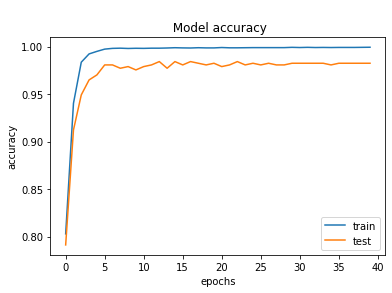

In [17]:
# list all data in history and plot accuracy of model
print(history.history.keys())
plot_acc(history)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.14      0.20      0.17         5

    accuracy                           0.98       570
   macro avg       0.57      0.59      0.58       570
weighted avg       0.99      0.98      0.98       570



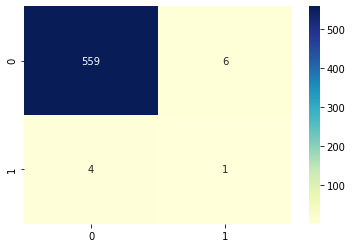

In [18]:
# predict validation set
y_pred = model.predict(x_valid)
# get confusion matrix
# input to confusion_matrix should be an array of int NOT one-hot encode
conf_matrix(y_valid_encoded.argmax(axis=1), y_pred.argmax(axis=1))

**Evaluate**

Since our test set is imbalanced, we shouldn’t rely solely on accuracy as a performance metric. Take a look on confusion matrix, our logistic regression has measly 0% recall, the precision even worse just around 0% (True Positive is 0). 

We should improve it by using a more complicated model.

**Build a simple Neural Network model**

We'll buil a neural network with 4 full-connected layer. Using Adam optimizer with learning rate 0.01, train over 40 epochs.

In [19]:
n_features = x_resampled.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_resampled, y_train_encoded, epochs=40, validation_data=(x_valid, y_valid_encoded))

Epoch 1/40
316/316 [==============================] - 1s 3ms/step - loss: 0.3591 - accuracy: 0.8814 - val_loss: 0.2250 - val_accuracy: 0.9684
Epoch 2/40
316/316 [==============================] - 1s 2ms/step - loss: 0.1235 - accuracy: 0.9896 - val_loss: 0.1220 - val_accuracy: 0.9842
Epoch 3/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0584 - accuracy: 0.9967 - val_loss: 0.0876 - val_accuracy: 0.9877
Epoch 4/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0320 - accuracy: 0.9979 - val_loss: 0.0733 - val_accuracy: 0.9895
Epoch 5/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9994 - val_loss: 0.0696 - val_accuracy: 0.9895
Epoch 6/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0126 - accuracy: 0.9994 - val_loss: 0.0684 - val_accuracy: 0.9895
Epoch 7/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0088 - accuracy: 0.9994 - val_loss: 0.0690 - val_accuracy: 0.9912
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


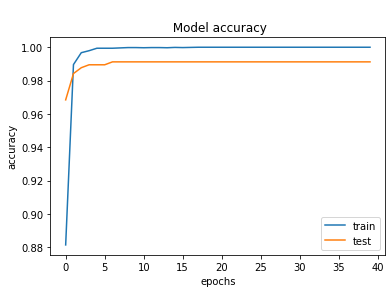

In [20]:
# list all data in history and plot accuracy of model
print(history.history.keys())
plot_acc(history)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


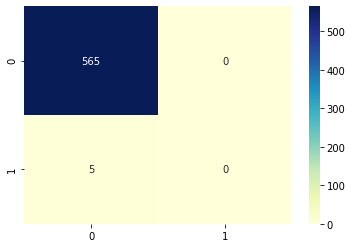

In [21]:
# predict validation set
y_pred = model.predict(x_valid)
# get confusion matrix
# input to confusion_matrix should be an array of int NOT one-hot encode
conf_matrix(y_valid_encoded.argmax(axis=1), y_pred.argmax(axis=1))

**Evaluate**

The performance seem improved when number of False Positive equal 0, but measly 0% recall, True Positive equal 0. Generally, this model still awful.

# **Threshold moving**
It seems that even building a complex network with multiple layers, it still does not improve the performace when the model just good at predicting label 0, and mislabel all of label 1. While our task here is trying to find a exoplanet (label 1).

Due to the model accuracy is evaluated based on the predicted results of all examples in validation set, but there is an imbalance problem in both train and validation set (99.12% label 0 in validation set). So, even our model mislabel all of label 1, the accuracy is 99.12%, too high but unreliable. 

[Threshold moving for Imbalanced Classification](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

**Threshold problem**

> *Mislabeling is maily caused by poor threshold.*

For those classification problems that have a severe class imbalance, the default threshold can result in poor performance. And the default threshold for classification problem in keras model is **0.5**. Unfortunately, the largest predited probability in validation set is **~0.0374**, that's mean there is no example with predicted probability >= 0.0374 (including examples labeled '1'). And values < default threshold (0.5) will be label '0', leading to all examples are labeled '0' (including examples with actual label '1').

In order to address this problem, we should find an appropriate threshold to distinguish between 2 classes.

**ROC curve**

ROC curve  is a performance measurement for classification problem in various thresholds setting. By using a set of different threshold, it interpret the **true positive rate** and **false positive rate** of the predictions on the positive (minority) class.

Here, we just need to get the set of thresholds used ROC curve and find the best threshold. So, we disregard plotting ROC curve or find AUC score for model. And we will use G-mean to examine which one is beast threshold.

In [22]:
from sklearn.metrics import roc_curve

def ROC_thresholds(y_test, y_pred):
  # calculate roc curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  # calculate the g-mean for each threshold
  # G-Mean is a metric for imbalanced classification, how large it is, shows how model's optimal
  gmeans = np.sqrt(tpr * (1-fpr))
  # locate the index of the largest g-mean
  ix = np.argmax(gmeans)
  # return the threshold which give out largest g-mean
  return thresholds[ix]

**Precision - Recall curve thresholds**

Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority) class only. Genarally, precision-recall curve use another set of thresholds for evaluating based on **precision** and **recall**.

And in order to find the best thrshold which give out the best balance of precision and recall, we use F-measure value instead of G-mean in ROC curve.

In [23]:
from sklearn.metrics import precision_recall_curve

def precision_recall_thresholds(y_test, y_pred):
  # calculate pr-curve
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  # convert to f score and remove NaN values
  fscore = (2 * precision * recall) / (precision + recall)
  fscore = fscore[np.logical_not(np.isnan(fscore))]
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  # return the threshold which give out largest f score
  return thresholds[ix]

**Simple neural network - binary classification**

We will apply the ROC curve and Precision-Recall curve to precisely evaluate the previous model. Here, for using predicted probability to find best threshold easier, we'll use sigmoid activtion function at final layer.

In [24]:
n_features = x_resampled.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_resampled, y_resampled, epochs=40, validation_data=(x_valid, y_valid))

Epoch 1/40
316/316 [==============================] - 1s 3ms/step - loss: 0.4290 - accuracy: 0.8711 - val_loss: 0.3168 - val_accuracy: 0.9544
Epoch 2/40
316/316 [==============================] - 1s 2ms/step - loss: 0.1873 - accuracy: 0.9850 - val_loss: 0.1670 - val_accuracy: 0.9842
Epoch 3/40
316/316 [==============================] - 1s 3ms/step - loss: 0.0900 - accuracy: 0.9949 - val_loss: 0.1059 - val_accuracy: 0.9842
Epoch 4/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0470 - accuracy: 0.9973 - val_loss: 0.0786 - val_accuracy: 0.9860
Epoch 5/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.0651 - val_accuracy: 0.9860
Epoch 6/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0169 - accuracy: 0.9989 - val_loss: 0.0616 - val_accuracy: 0.9912
Epoch 7/40
316/316 [==============================] - 1s 2ms/step - loss: 0.0114 - accuracy: 0.9993 - val_loss: 0.0595 - val_accuracy: 0.9912
Epoch 

Best ROC threshold: 2.4976136e-05
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       565
           1       0.02      0.40      0.04         5

    accuracy                           0.82       570
   macro avg       0.51      0.61      0.47       570
weighted avg       0.99      0.82      0.90       570



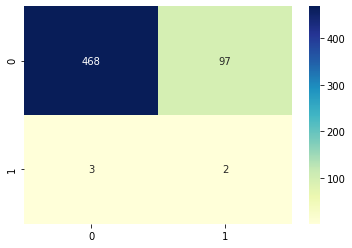

In [25]:
# predict validation set
y_pred = model.predict(x_valid)

# get best threshold using ROC curve
roc_threshold = ROC_thresholds(y_valid, y_pred)
print('Best ROC threshold:', roc_threshold)

# re-classificate using new threshold
y_pred[y_pred < roc_threshold] = 0
y_pred[y_pred >= roc_threshold] = 1

# get confusion matrix
conf_matrix(y_valid, y_pred)

Best precision-recall threshold: 0.00094653893
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       565
           1       0.04      0.20      0.07         5

    accuracy                           0.95       570
   macro avg       0.52      0.58      0.52       570
weighted avg       0.98      0.95      0.97       570



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


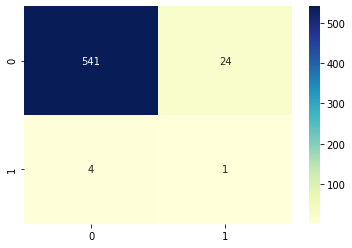

In [26]:
# re-predict validation set
y_pred = model.predict(x_valid)

# get best threshold using precision-recall curve
precision_recall_threshold = precision_recall_thresholds(y_valid, y_pred)
print('Best precision-recall threshold:', precision_recall_threshold)

## re-classificate using new threshold
y_pred[y_pred < precision_recall_threshold] = 0
y_pred[y_pred >= precision_recall_threshold] = 1

# get confusion matrix
conf_matrix(y_valid, y_pred)

**Evaluate**

For ROC curve case, even accuracy decreased to 65%, but recall get 60% and precision 1%. It's quite good when we have succesfully precisely predicted 3/5 exoplanet.

For precision-recall curve case, it's quite balance in precision-recall trade-off when accuracy is 97% but recall 20% and precision 7%. 

The balance of precision-recall does not seem to bother. We'll just use ROC curve from now on.

**More complicated neural network**

Seem like we got the right approach, now let build a more complicated neural network to see how good on performance can improve. Here, I will try on one of famous neural network architechrue, Alexnet.

In [27]:
n_features = x_resampled.shape[1]

#Instantiation
alexnet = Sequential()

#1st Convolutional Layer
alexnet.add(Conv1D(filters=96, input_shape=(n_features,1), kernel_size=11, strides=4, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

#2nd Convolutional Layer
alexnet.add(Conv1D(filters=256, kernel_size=5, strides=1, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

#3rd Convolutional Layer
alexnet.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

#4th Convolutional Layer
alexnet.add(Conv1D(filters=384, kernel_size=3, strides=1, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))

#5th Convolutional Layer
alexnet.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same'))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
alexnet.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

#Passing it to a Fully Connected layer
alexnet.add(Flatten())
# 1st Fully Connected Layer
alexnet.add(Dense(4096, input_shape=(32,32,3,)))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
# Add Dropout to prevent overfitting
alexnet.add(Dropout(0.4))

#2nd Fully Connected Layer
alexnet.add(Dense(4096))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
#Add Dropout
alexnet.add(Dropout(0.4))

#3rd Fully Connected Layer
alexnet.add(Dense(1000))
alexnet.add(BatchNormalization())
alexnet.add(Activation('relu'))
#Add Dropout
alexnet.add(Dropout(0.4))

#Output Layer
alexnet.add(Dense(1))
alexnet.add(BatchNormalization())
alexnet.add(Activation('sigmoid'))

#Model Summary
alexnet.summary()

# Compiling the model
alexnet.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 800, 96)           1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 800, 96)           384       
_________________________________________________________________
activation (Activation)      (None, 800, 96)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 400, 96)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 256)          123136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 400, 256)         

In [28]:
# add extra dimension on both train and validation set for Conv1D
x_train_new = np.expand_dims(x_resampled, axis=2)
x_valid_new = np.expand_dims(x_valid, axis=2)
print(x_train_new.shape)
print(x_resampled.shape)

# fit data to model
history = alexnet.fit(x_train_new, y_resampled, epochs=25)

(10100, 3197, 1)
(10100, 3197)
Epoch 1/25
316/316 [==============================] - 10s 31ms/step - loss: 0.2982 - accuracy: 0.9882
Epoch 2/25
316/316 [==============================] - 10s 31ms/step - loss: 0.2247 - accuracy: 0.9974
Epoch 3/25
316/316 [==============================] - 10s 31ms/step - loss: 0.1818 - accuracy: 0.9971
Epoch 4/25
316/316 [==============================] - 10s 31ms/step - loss: 0.1490 - accuracy: 0.9969
Epoch 5/25
316/316 [==============================] - 10s 31ms/step - loss: 0.1226 - accuracy: 0.9981
Epoch 6/25
316/316 [==============================] - 10s 31ms/step - loss: 0.1026 - accuracy: 0.9983
Epoch 7/25
316/316 [==============================] - 10s 31ms/step - loss: 0.0877 - accuracy: 0.9981
Epoch 8/25
316/316 [==============================] - 10s 31ms/step - loss: 0.0747 - accuracy: 0.9982
Epoch 9/25
316/316 [==============================] - 10s 31ms/step - loss: 0.0648 - accuracy: 0.9989
Epoch 10/25
316/316 [==============================

Best ROC threshold: 0.006486453
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       565
           1       0.38      1.00      0.56         5

    accuracy                           0.99       570
   macro avg       0.69      0.99      0.77       570
weighted avg       0.99      0.99      0.99       570



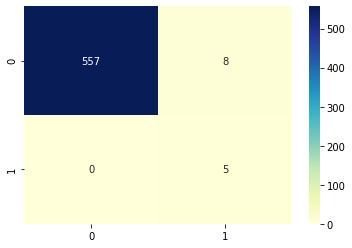

In [29]:
# predict validation set
y_pred = alexnet.predict(x_valid_new)

# get best threshold using ROC curve
roc_threshold = ROC_thresholds(y_valid, y_pred)
print('Best ROC threshold:', roc_threshold)

# re-classificate using new threshold
y_pred[y_pred < roc_threshold] = 0
y_pred[y_pred >= roc_threshold] = 1

# get confusion matrix
conf_matrix(y_valid, y_pred)

**Evaluate**

Amazing! We got a stunning result. Not only accuracy achived 99%, but also recall 100% and precision 38%. On top of that, we have successfully precise predicted 5/5 exoplanet and the number of False Positive mislabeled is very low as well. 

Prepare yourself and fly into space in search of a habitable exo-planet out of any planets we have predicted :)